# Titanic Survivor Dataset

This is my first ML project from Kaggle. The dataset have various information about pepole who survived or died from the tragedy. Using this data, I will build a model and predict the probability of other people's survival using their features like sex, age, fare, etc. 

# 0. Import Libraries

In [1]:
# Imports
import pandas as pd
from pandas import Series, DataFrame
import pandas_profiling

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

# ignore Deprecation Warning
import warnings
#warnings.filterwarnings("ignore", category=DeprecationWarning,RuntimeWarning) 
warnings.filterwarnings("ignore") 

# 1. Load and Check Data
Load data and pre-process to feed into ML. 


### 1.1 Load data

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')

# Some quick inspections
print(train_df.shape, test_df.shape, '\n', train_df.columns.values, '\n', test_df.columns.values)

(891, 12) (418, 11) 
 ['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked'] 
 ['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


There are 891 entries in train dataset, with 12 features. 
There are 418 entries in test dataset, with 11 features. The missing one is the "Survived" feature, which should be the results from our prediction.

In [3]:
#train_df.info()
#print("----------------------------")
#test_df.info()

In [4]:
pandas_profiling.ProfileReport(train_df)

Number of variables,12
Number of observations,891
Total Missing (%),8.1%
Total size in memory,83.6 KiB
Average record size in memory,96.1 B
Numeric,6
Categorical,4
Boolean,1
Date,0
Text (Unique),1
Rejected,0


"Age", "Cabin", "Embarked", "Fare" have null values. 
Categorical variables are: "Name","Sex","Ticket","Cabin"&"Embarked"

In [5]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### 1.2 Outlier Detection

- Outliers can be exactly what we want to learn about, especially for tasks like anomaly detection. 

- In this study, however, outliers distort the picture of the data in both statistical analysis and visualization. They may be havoc with many ML algorithms and models. Thereby in prediction, the models may be improved by ignoring the outliers. 

- Below we use the Modified Z-score method & the IQR Method. Note that the variable must be continuous, not categorical, for any of these functions to make sense.

In [6]:
def outliers_modified_z_score(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices corresponding to the observations containing more than n outliers according to the modified z-score Method
    """
    threshold = 3.5
    outlier_indices = []
    for col in features:
        median_y = np.median(dataframe[col])
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in dataframe[col]])
        modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in dataframe[col]]
        outlier_list_col = dataframe[np.abs(modified_z_scores) > threshold].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers  

In [7]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop_1 = outliers_modified_z_score(train_df,2,["Age","SibSp","Parch","Fare"])

In [8]:
train_df[["Age","SibSp","Parch","Fare"]].loc[Outliers_to_drop_1] # Show the outliers rows

,Age,SibSp,Parch,Fare
27,19.00,3,2,263.0000
88,23.00,3,2,263.0000
159,NaN,8,2,69.5500
180,NaN,8,2,69.5500
201,NaN,8,2,69.5500
248,37.00,1,1,52.5542
262,52.00,1,1,79.6500
297,2.00,1,2,151.5500
305,0.92,1,2,151.5500
311,18.00,2,2,262.3750


In [9]:
def outliers_iqr(dataframe, n, features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    for col in features:
        # 1st quartile (25%) & # 3rd quartile (75%)
        quartile_1, quartile_3 = np.percentile(dataframe[col], [25,75])
        #quartile_3 = np.percentile(dataframe[col], 75)
      
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_1 - (iqr * 1.5)
        upper_bound = quartile_3 + (iqr * 1.5)
        # Determine a list of indices of outliers for feature col
        outlier_list_col = dataframe[(dataframe[col] < lower_bound) | (dataframe[col] > upper_bound)].index
       # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    return multiple_outliers   

In [10]:
# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = outliers_iqr(train_df,2, ["Age","SibSp","Parch","Fare"])

In [11]:
train_df[["Age","SibSp","Parch","Fare"]].loc[Outliers_to_drop] # Show the outliers rows

,Age,SibSp,Parch,Fare
27,19.0,3,2,263.00
88,23.0,3,2,263.00
159,NaN,8,2,69.55
180,NaN,8,2,69.55
201,NaN,8,2,69.55
324,NaN,8,2,69.55
341,24.0,3,2,263.00
792,NaN,8,2,69.55
846,NaN,8,2,69.55
863,NaN,8,2,69.55


We detect 10 outliers. The 28, 89 and 342 passenger have an high 
Ticket Fare

The 7 others have very high values of SibSP.

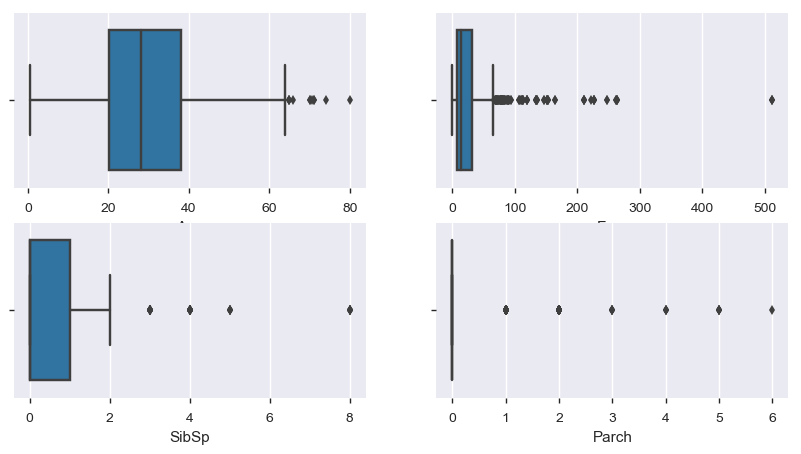

In [12]:
fig, ((axis1, axis2), (axis3, axis4)) = plt.subplots(2,2, sharex=False, figsize=(10,5))
sns.boxplot('Age', data=train_df, ax=axis1)
sns.boxplot('Fare',data=train_df, ax=axis2)
sns.boxplot('SibSp', data=train_df, ax=axis3)
sns.boxplot('Parch',data=train_df)


Here I use the box-and-whisker plot to show the distribution of the selected features. The box shows the quartiles of the dataset while the whiskers extend to show the rest of the distributions, except for "outliers" using IQR method. 
The most standing-out outlier is the one in the "Fare". 

In [13]:
# Drop outliers
train_df = train_df.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

### 1.3 Join train and test dataset

In [14]:
## Join train and test datasets 
df = train_df.append(test_df, ignore_index=True)
train_len = len(train_df)
#dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

### 1.4 Check for null and missing values

In [15]:
# Fill empty and NaNs values with NaN
df.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

- "Age" and "Cabin" features have significant amount of missing values."Embarked" and "Fare" also have null values. Survived missing values correspond to the testing dataset (Survived column doesn't exist in test set)

- Numerical features: "Age", "Sibsp", "Parch", "Fare". 

- Categorical/Non-numerical features: "PassengerID","Pclass","Name", "Sex", "Ticket", "Cabin", "Embarked"
Below I will analyze these two types of features seperately. 

# 2. Feature Analysis
Missing values will be filled. Categorical feastures will be transformed to numberical values.

## 2.1 Numerical Values

### 2.1.1 Correlation between numberical values
Look at the Correlation matrix between numerical values (SibSp, Parch, Age and Fare)

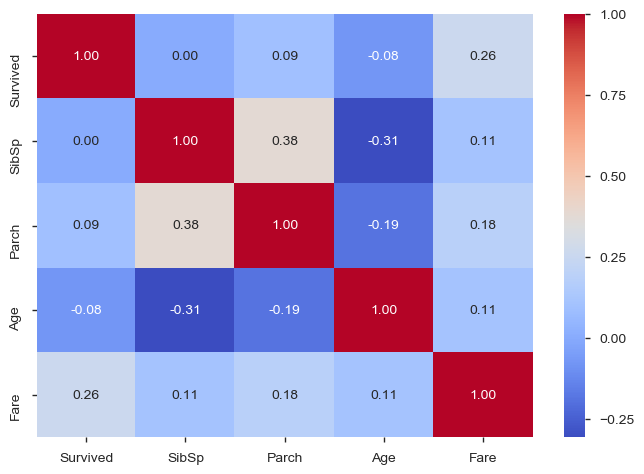

In [16]:
cm_df = sns.heatmap(train_df[["Survived","SibSp","Parch","Age","Fare"]].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

Only Fare seems to have a significant correlation with the survival probility (0.26). 
These pairs seem to be correlated too: 
- SibSp vs Parch (0.38)
- Fare vs Parch (0.22)
There pairs seem to be anti-correlated:
- SibSp vs Age (-0.31)

Next, I will look at each feature. 

# Parch & SibSp
 

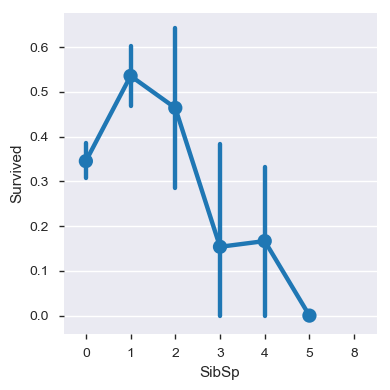

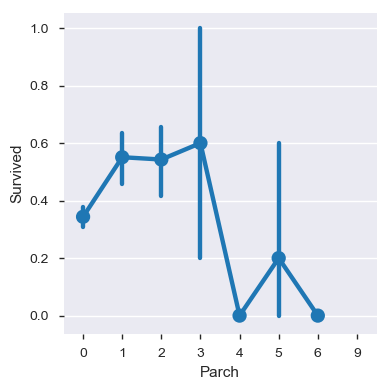

In [17]:
# Explore SibSp feature vs Survived
#fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,3))
sns.factorplot(x="SibSp",y="Survived",data=df)
#axis1.set_ylabels("survival probability")
sns.factorplot(x="Parch",y="Survived",data=df)

- Passengers with more families have lower probability to survive.There is a clear devision in the survival of passengers with 3 parents/children
- Instead of having 2 columns, Parch and SibSp, we can have only one column representing if the passenger had any families aboard.

In [18]:
df['Family'] = df['Parch'] + df['SibSp']+1
# inspect the correlation between Family and Survived
df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.200000
5,6,0.052632
6,7,0.333333
7,8,0.000000
8,11,NaN


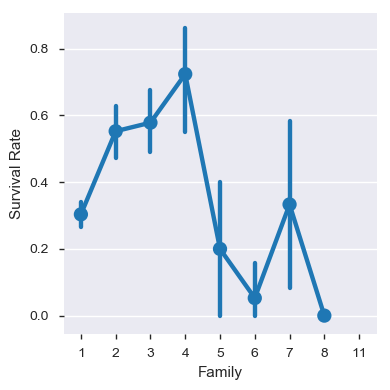

In [19]:
g=sns.factorplot(x="Family",y="Survived",data=df)
g.set_ylabels('Survival Rate')

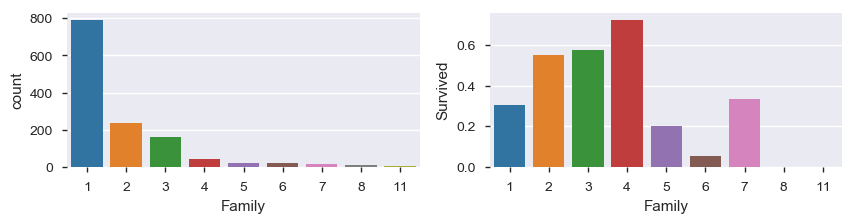

In [20]:
# the number of family members
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Family', data=df, ax=axis1)

# average of survived for those who had/didn't have any families
family_perc = df[['Family','Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

In [21]:
# inspect the family size
df['Family'].value_counts()

1     790
2     235
3     159
4      43
6      22
5      22
7      16
8       8
11      4
Name: Family, dtype: int64

The survival rate increases with the family size till Family>=5. However, the number of family with >=5 members is only 57. Besides, people with big families (>=5) have a low survival rate too. Thereby, I will combine the data with Family>4 into one category, Family=5 

In [22]:
df.Family = df.Family.map(lambda x: 5 if x>4 else x)
df[['Family','Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,1,0.303538
1,2,0.552795
2,3,0.578431
3,4,0.724138
4,5,0.153846


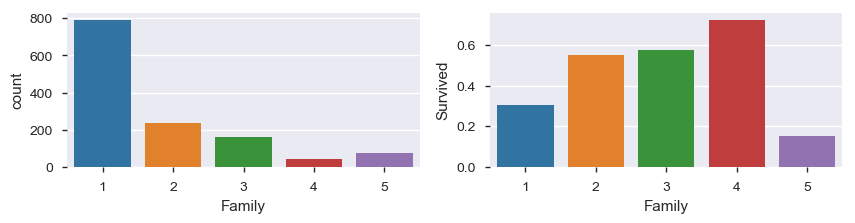

In [23]:
# the number of family members
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Family', data=df, ax=axis1)

# average of survived for those who had/didn't have any families
family_perc = df[['Family','Survived']].groupby(['Family'], as_index=False).mean()
sns.barplot(x='Family',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

In [24]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1


In [25]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1


In [26]:
# convert to indicator values 
df = pd.get_dummies(df, columns=['Family'], prefix='Fsize')


#embark_dummies_df = pd.get_dummies(df['Embarked'])
##embark_dummies_df.drop('S', axis=1, inplace=True)

#df = df.join(embark_dummies_df)

In [27]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize_1,Fsize_2,Fsize_3,Fsize_4,Fsize_5
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,1,0,0,0
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,1,0,0,0
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,0,0,0,0
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0,1,0,0,0
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,0,0,0,0


### Age

In [28]:
df.Age.isnull().sum()

256

There are 256 missing values in Age. This can probably be inferred from other feasures, e.g., Title, Fare, SibSp, Parch, etc.

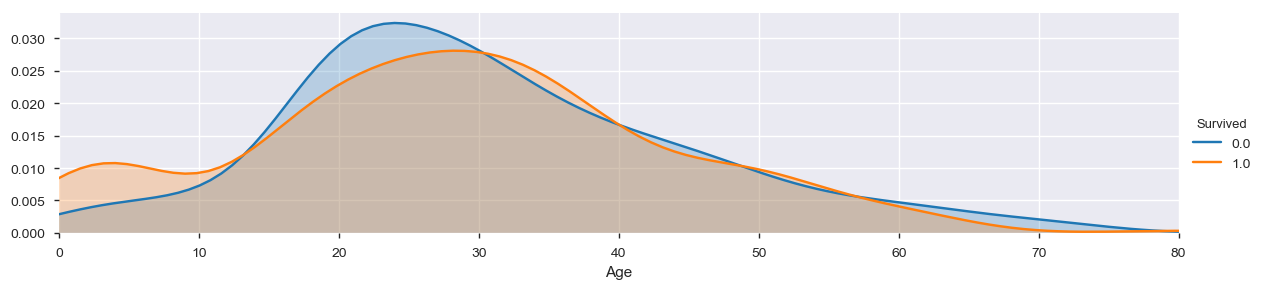

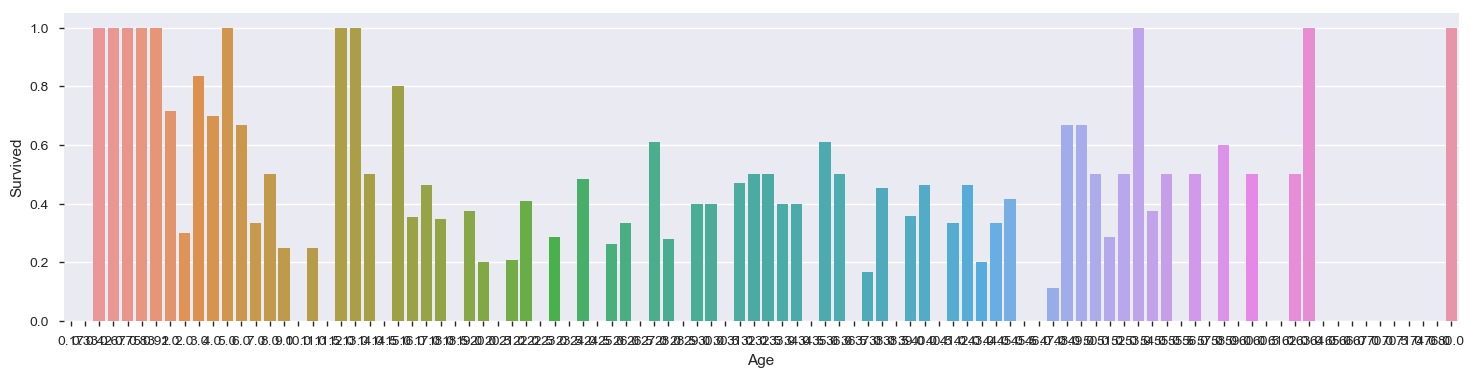

In [29]:
# peaks for survived/not survived passengers by their age
facet = sns.FacetGrid(df, hue = 'Survived', aspect=4)
#facet.map(sns.distplot, 'Age')
facet.map(sns.kdeplot, 'Age', shade=True)
facet.set(xlim=(0, df['Age'].max()))
facet.add_legend()
plt.xlim(0, 80)


# Averge survived passeangers by age
fig, axis1 = plt.subplots(1, 1, figsize=(18,4))
average_age = df[['Age','Survived']].groupby(['Age'], as_index=False).mean()
sns.barplot(x='Age', y='Survived', data=average_age)

- Age distribution seems to be a skewed Gaussian distribution. 
- The distributions for survived and not survived people are different. The peak age for survived people is ~ 30, while the one for not survived people is ~ 25. 
- There are more people with age < 10 (children) survived, while fewer people with age > 60 survived. 
- As this feature is correlated with the survival rate, I will fill in the missing values and look at the most correlated features with Age (SibSp, Pclass, Parch and Sex). 


In [30]:
ind_age_NAN = list(df['Age'][df['Age'].isnull()].index)

In [31]:
for i in ind_age_NAN :
    age_med = df["Age"].median()
    age_pred = df["Age"][((df['SibSp'] == df.iloc[i]["SibSp"]) & (df['Parch'] == df.iloc[i]["Parch"]) & (df['Pclass'] == df.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        df['Age'].iloc[i] = age_pred
    else:
        df['Age'].iloc[i] = age_med    

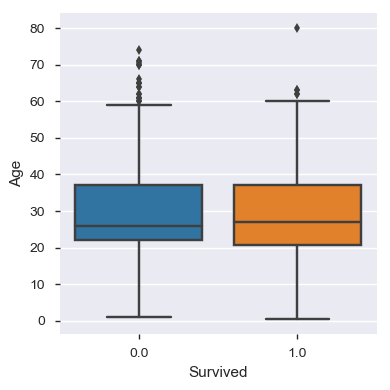

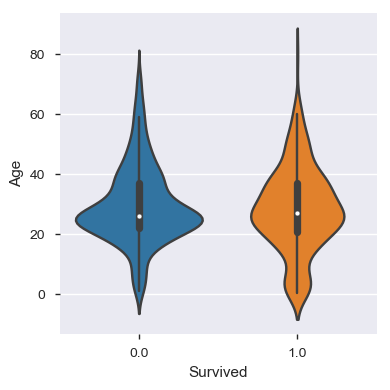

In [32]:
sns.factorplot(x="Survived", y = "Age",data = df, kind="box")
sns.factorplot(x="Survived", y = "Age",data = df, kind="violin")


### Fare

In [33]:
# check if there is any NAN
df.Fare.isnull().sum(axis=0)

1

Only one missing Fare value. I will fill it with the median value. 

In [34]:
print(df.Ticket[df.Fare.isnull()],'\n', df.Pclass[df.Fare.isnull()], '\n', df.Embarked[df.Fare.isnull()], '\n', df.Cabin[df.Fare.isnull()])

1033    3701
Name: Ticket, dtype: object 
 1033    3
Name: Pclass, dtype: int64 
 1033    S
Name: Embarked, dtype: object 
 1033    NaN
Name: Cabin, dtype: object


There is no corresponding value for Cabin, so only look at the relation between Fare and the other three feasures

In [35]:
df['Fare'] = df['Fare'].fillna(df['Fare'].median())

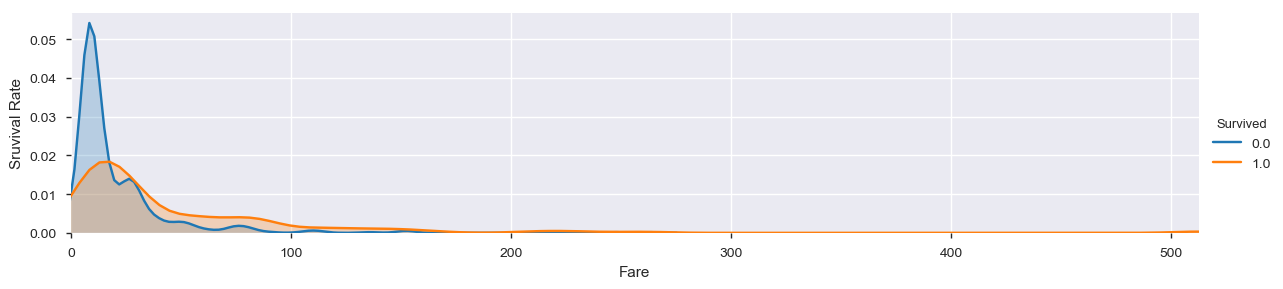

In [36]:
# peaks for survived/not survived passengers by their fare
facet = sns.FacetGrid(df, hue = 'Survived', aspect=4)
#facet.map(sns.distplot, 'Age')
facet.map(sns.kdeplot, 'Fare', shade=True)
facet.set(xlim=(0, df['Fare'].max()))
facet.add_legend()
facet.set_ylabels('Sruvival Rate')

In [37]:
print(df["Fare"].skew())

4.51186201158


As we can see the Fare distributions are very right-skewed for both Survived and not Survived. The skewness may cause overweight of the high-end values in the model. Thereby, I log-transform it in order to reduce the skewness

In [38]:
df['Fare'] = df['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

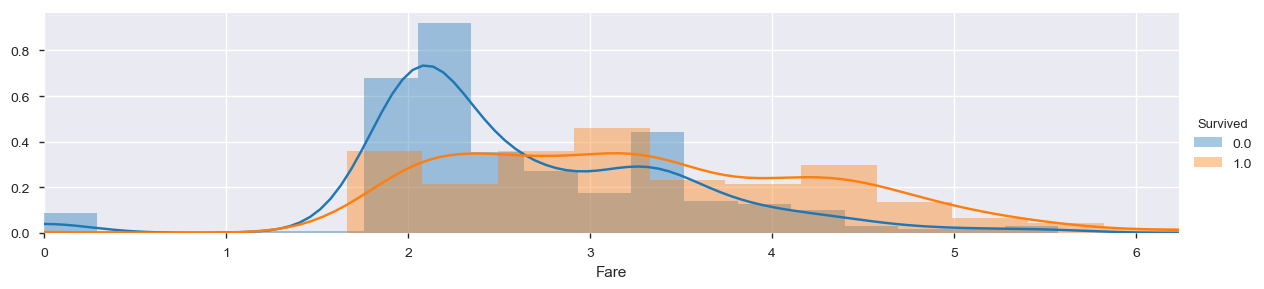

In [39]:
# peaks for survived/not survived passengers by their fare
facet = sns.FacetGrid(df, hue = 'Survived', aspect=4)
facet.map(sns.distplot, 'Fare')
facet.set(xlim=(0, df['Fare'].max()))
facet.add_legend()

In [40]:
print(df["Fare"].skew())

0.572799662008


In [41]:
df.Fare.head()

0    1.981001
1    4.266662
2    2.070022
3    3.972177
4    2.085672
Name: Fare, dtype: float64

In [42]:
# bin Fare into five intervals with equal amount of people
df['Fare_bin'] = pd.qcut(df.Fare,5,labels=[1,2,3,4,5]).astype(int)

# inspect the correlation between Fare-bin and Survived
df[['Fare_bin', 'Survived']].groupby(['Fare_bin'], as_index=False).mean()

,Fare_bin,Survived
0,1,0.217877
1,2,0.201087
2,3,0.437126
3,4,0.432432
4,5,0.668675


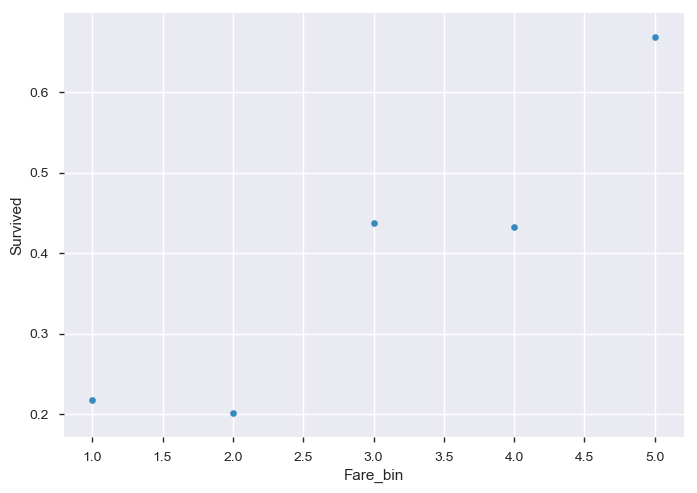

In [43]:
df[['Fare_bin','Survived']].groupby(['Fare_bin'],as_index=False).mean().plot.scatter('Fare_bin','Survived')
            

Now the correlation between Fare and Survived is clear after the binning

In [44]:
df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Fsize_1,Fsize_2,Fsize_3,Fsize_4,Fsize_5,Fare_bin
0,22.0,NaN,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,0,1,0,0,0,1
1,38.0,C85,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,0,1,0,0,0,5
2,26.0,NaN,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,0,0,0,0,2
3,35.0,C123,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,0,1,0,0,0,5
4,35.0,NaN,S,2.085672,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,0,0,0,0,2


### 2.2 Categorical Values

### Cabin

In [45]:
# check if there is any NAN
df.Cabin.isnull().sum(axis=0)

1007

This is highly imcomplete. There are two choices: (1)map the missing ones to a new category "unknown" (2) drop this feasure. 

In [46]:
df.Cabin.head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [47]:
df.Cabin[df.Cabin.notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

The first letter of the cabin probably indicates the Desk, Thereby I  chose to keep this information only, since it indicates the probable location of the passenger in the Titanic.

In [48]:
# Replace the Cabin number by the type of cabin 'X' if not
df.Cabin = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df.Cabin ])

In [49]:
df.Cabin.head()

0    X
1    C
2    X
3    C
4    X
Name: Cabin, dtype: object

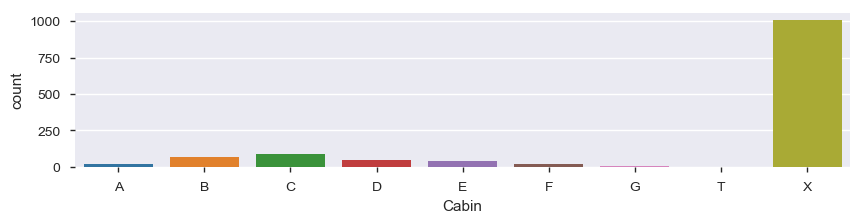

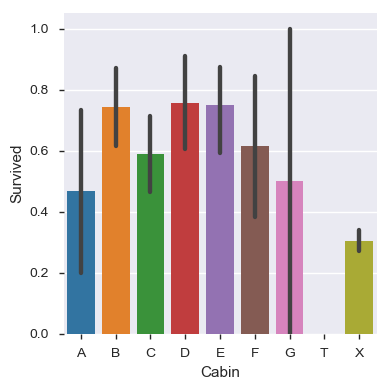

In [50]:
#fig, (axis1, axis2) = plt.subplots(1,2, figsize=(10,2))
fig, ax1 = plt.subplots(figsize=(10,2))
sns.countplot(df["Cabin"], order=['A','B','C','D','E','F','G','T','X'], ax=ax1)
#fig, ax2 = plt.subplots(figsize=(10,2))
sns.factorplot(y="Survived",x="Cabin", data=df,kind="bar", order=['A','B','C','D','E','F','G','T','X'])

Because of the low number of passenger that have a cabin, survival probabilities have an important standard deviation and we can't distinguish between survival probability of passengers in the different desks.

But we can see that passengers with a cabin have generally more chance to survive than passengers without (X).

It is particularly true for cabin B, D and E.

In [51]:
df = pd.get_dummies(df, columns = ["Cabin"],prefix="Cabin")

In [52]:
df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Fare_bin,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,22.0,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,...,1,0,0,0,0,0,0,0,0,1
1,38.0,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,...,5,0,0,1,0,0,0,0,0,0
2,26.0,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,...,2,0,0,0,0,0,0,0,0,1
3,35.0,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,...,5,0,0,1,0,0,0,0,0,0
4,35.0,S,2.085672,"Allen, Mr. William Henry",0,5,3,male,0,0.0,...,2,0,0,0,0,0,0,0,0,1


### Embarked

In [53]:
# check if there is any NAN
df.Embarked.isnull().sum(axis=0)

2

In [54]:
df['Embarked'].value_counts()

S    904
C    270
Q    123
Name: Embarked, dtype: int64

In [55]:
df = df.fillna({'Embarked':'S'})

"S" is the most occurred value. Thereby we will fill nulll values with "S"

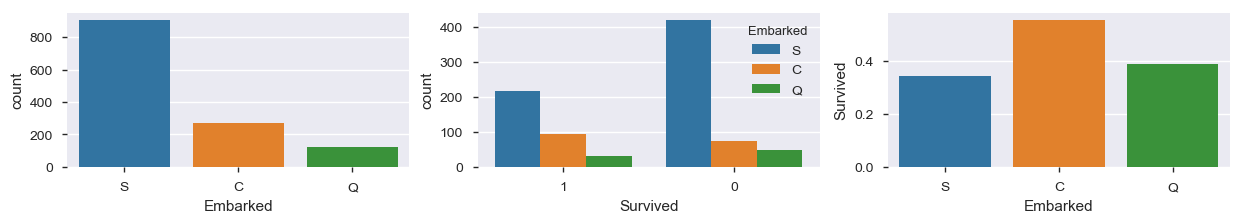

In [56]:
# inspect the correlation between Embarked and Survived as well as some other features

#sns.factorplot('Embarked', 'Survived', data=df, size=2, aspect=2)

fig, (axis1, axis2, axis3) = plt.subplots(1,3,figsize=(15,2))
sns.countplot(x='Embarked', data=df, ax=axis1)
sns.countplot(x='Survived', hue='Embarked',data=df, order=[1,0],ax=axis2)

# group by embarked, and get the mean for survived passengers for each value in Embarked
embark_perc = df[['Embarked','Survived']].groupby(['Embarked'],as_index=False).mean()
sns.barplot(x='Embarked', y='Survived',data=embark_perc, order=['S','C','Q'],ax=axis3)

- The most passengers embarked from 'S' station, followed by 'C' and 'Q'
- The trend remains when we grouped them by Survived or not. 
- Survived people are mostly embarked from 'C'. 
My guess is that the Fare for "C" is also higher and they are mostly from first class. 

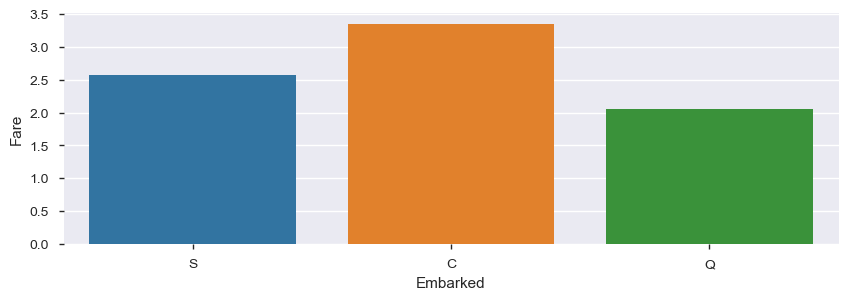

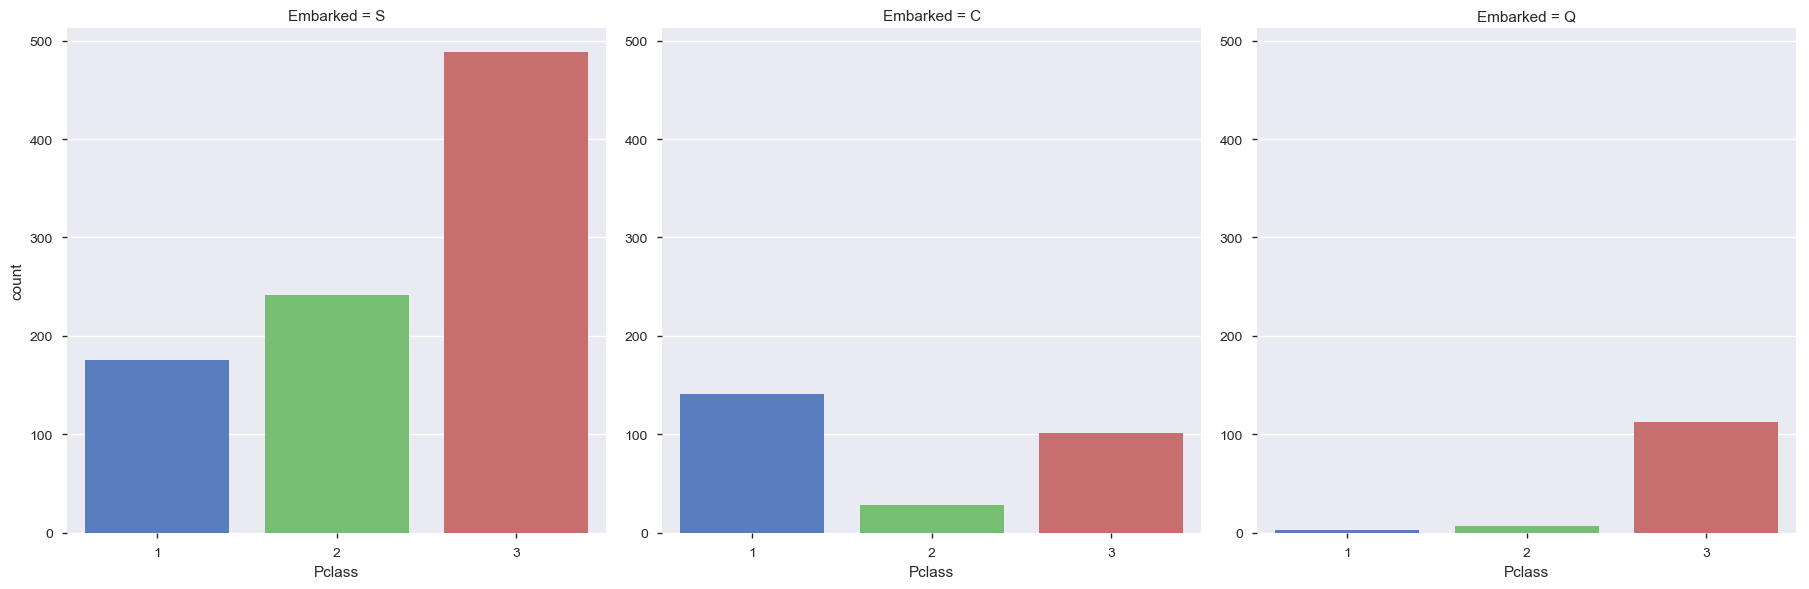

In [57]:
fare_perc = df[['Embarked','Fare']].groupby(['Embarked'],as_index=False).median()
fig, ax = plt.subplots(figsize=(10,3))
sns.barplot(x='Embarked', y='Fare',data=fare_perc, order=['S','C','Q'], ax=ax)

sns.factorplot("Pclass", col="Embarked",  data=df,
                   size=6, kind="count", palette="muted")


Indeed, the most passengers from "S" and "Q" are in the 3rd class, whereas the most passengers from "C" are in the first class. The mean Fare price for "C" is also the highest. 

In [58]:
#df[['Embarked', 'Survived','Pclass','Fare', 'Age', 'Sex']].groupby(['Embarked'], as_index=False).mean()
df[['Embarked', 'Survived','Pclass','Fare', 'Age']].groupby(['Embarked'], as_index=False).mean()

,Embarked,Survived,Pclass,Fare,Age
0,C,0.553571,1.851852,3.463230,31.349704
1,Q,0.389610,2.894309,2.302756,26.516260
2,S,0.341195,2.344371,2.809053,29.031733


The survival rate changes with Embarked but it may actually due to other feasures, e.g., Pclass, Fare and Age. 

In [59]:
#  Remove 'S' dummy variable, and leave 'C' and 'Q', since they seem to have a good rate for survival. 
embark_dummies_df = pd.get_dummies(df['Embarked'])
#embark_dummies_df.drop('S', axis=1, inplace=True)
df = df.join(embark_dummies_df)

In [60]:
df.head()

,Age,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X,C,Q,S
0,22.0,S,1.981001,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,...,0,0,0,0,0,0,1,0,0,1
1,38.0,C,4.266662,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,...,1,0,0,0,0,0,0,1,0,0
2,26.0,S,2.070022,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,...,0,0,0,0,0,0,1,0,0,1
3,35.0,S,3.972177,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,...,1,0,0,0,0,0,0,0,0,1
4,35.0,S,2.085672,"Allen, Mr. William Henry",0,5,3,male,0,0.0,...,0,0,0,0,0,0,1,0,0,1


In [61]:
#df.drop(['Embarked'], axis=1,inplace=True)

### Name

In [62]:
df.Name.head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [63]:
df['Title'] = df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip())
# inspect the amount of people for each title
df.Name.map( lambda x: x.split(',')[1].split( '.' )[0].strip()).value_counts()

Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Dona              1
the Countess      1
Jonkheer          1
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
Name: Name, dtype: int64

The main titles are: "Mr","Miss","Mrs" & "Master". Some of the others can be merged into one of the four categories. The rest will be merged into "Others"

In [64]:
df['Title'] = df['Title'].replace(['Mme','Lady','Ms','Mille','Miss'], 'Mrs')
df.Title.loc[ (df.Title != 'Master') & (df.Title != 'Mr') & (df.Title != 'Mrs')] = 'Others'
# inspect the correlation between Title and Survived
#df[['Title','Survived']].groupby(['Title'], as_index=False).mean()

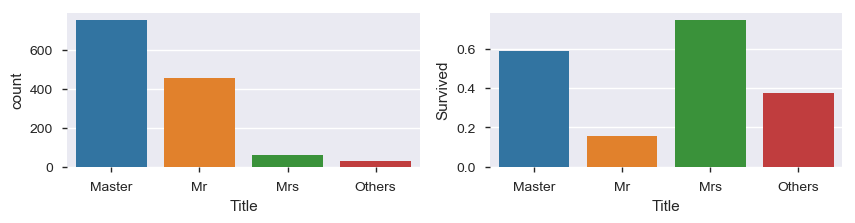

In [65]:
# inspect the amount of people for each title
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Title', data=df,ax=axis1)
#sns.factorplot('Family', data=train_df, kind='count', ax=axis2)

# average of survived for those who had/didn't have any families
family_perc = df[['Title','Survived']].groupby(['Title'], as_index=False).mean()
sns.barplot(x='Title',y='Survived',data=family_perc, ax=axis2)
#axis1.set_xticklabels(['With Family','Alone'],rotation=0)

"Women and childen first"?

In [66]:
df['Title'].value_counts()

Mr        753
Mrs       456
Master     60
Others     30
Name: Title, dtype: int64

Now we can use dummy variables for these titles and drop the orginal columns. 

In [67]:
df = pd.concat([df, pd.get_dummies(df['Title'])], axis=1).drop(labels=['Name'], axis=1)

Title can be indicative of the Age. 

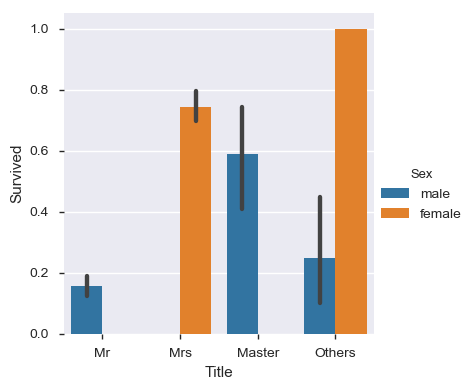

In [68]:
# inspect the amount of people for each title
sns.factorplot(x='Title',y='Survived',hue='Sex', data=df, kind='bar')

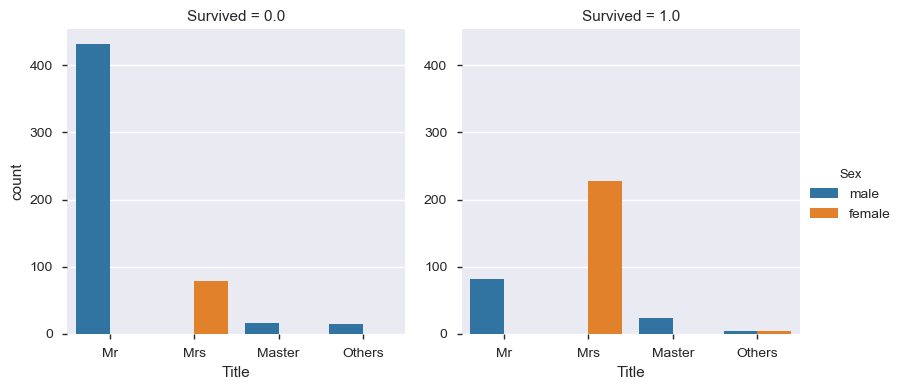

In [69]:
sns.factorplot(x='Title',col='Survived',hue='Sex', data=df, kind='count')

Check the gender in "Others"

In [70]:
df.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,Cabin_T,Cabin_X,C,Q,S,Title,Master,Mr,Mrs,Others
0,22.0,S,1.981001,0,1,3,male,1,0.0,A/5 21171,...,0,1,0,0,1,Mr,0,1,0,0
1,38.0,C,4.266662,0,2,1,female,1,1.0,PC 17599,...,0,0,1,0,0,Mrs,0,0,1,0
2,26.0,S,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,...,0,1,0,0,1,Mrs,0,0,1,0
3,35.0,S,3.972177,0,4,1,female,1,1.0,113803,...,0,0,0,0,1,Mrs,0,0,1,0
4,35.0,S,2.085672,0,5,3,male,0,0.0,373450,...,0,1,0,0,1,Mr,0,1,0,0


### Pclass

In [71]:
# check if there are any null values
df['Pclass'].isnull().sum(axis=0)

0

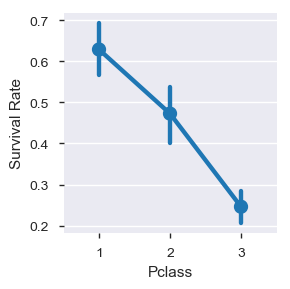

In [72]:
# inspect the corrleatoin between Pclass and survived
#df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean()
g= sns.factorplot('Pclass','Survived', order=[1,2,3],data=train_df,size=3)
g.set_ylabels('Survival Rate')

We can see that a higher class has a higher survival rate. 

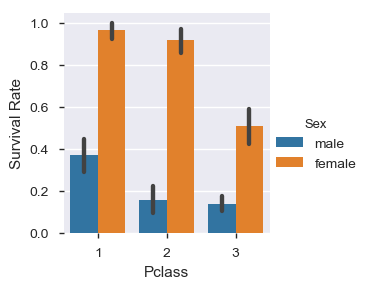

In [73]:
# inspect the corrleatoin between Pclass and survived by Sex
g= sns.factorplot('Pclass','Survived', hue ='Sex', order=[1,2,3],data=train_df, kind = 'bar', size=3)
g.set_ylabels('Survival Rate')

The trend remains when adding in the gender infromation

Create dummy variable for Pclass & drop the 3 rd class as it has the lowest average of survived passengers

In [74]:
pclass_dummies_df = pd.get_dummies(df['Pclass'])
pclass_dummies_df.columns = ['Class1','Class2','Class3']
#pclass_dummies_df.drop(['Class3'], axis=1, inplace=True)

#df.drop(['Pclass'], axis=1, inplace=True)

df = df.join(pclass_dummies_df)



In [75]:
df.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,Q,S,Title,Master,Mr,Mrs,Others,Class1,Class2,Class3
0,22.0,S,1.981001,0,1,3,male,1,0.0,A/5 21171,...,0,1,Mr,0,1,0,0,0,0,1
1,38.0,C,4.266662,0,2,1,female,1,1.0,PC 17599,...,0,0,Mrs,0,0,1,0,1,0,0
2,26.0,S,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,...,0,1,Mrs,0,0,1,0,0,0,1
3,35.0,S,3.972177,0,4,1,female,1,1.0,113803,...,0,1,Mrs,0,0,1,0,1,0,0
4,35.0,S,2.085672,0,5,3,male,0,0.0,373450,...,0,1,Mr,0,1,0,0,0,0,1


### Sex

As we see in "Age" analysis, children (age<16) on aboard seem to have a high chances for survival. so we can classify passengers as males, females, and child

In [76]:
df.Sex.isnull().sum(axis=0)

0

In [77]:
df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean()

,Sex,Survived
0,female,0.747573
1,male,0.190559


In [78]:
# map the two genders to 0 and 1
# df.Sex = df.Sex.map({'male':0, 'female':1})

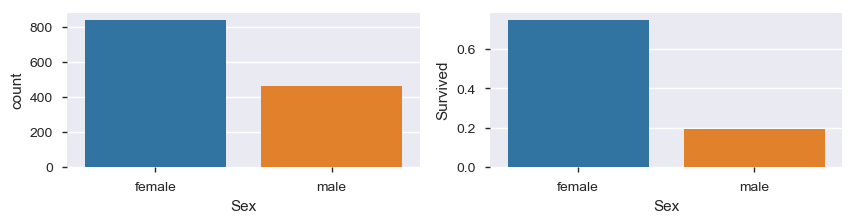

In [79]:
# inspect the correlation between Sex and Survived 
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Sex', data=df, ax=axis1)

sex_perc = df[['Sex','Survived']].groupby(['Sex'], as_index=False).mean()
sns.barplot(x='Sex',y='Survived',data=sex_perc, ax=axis2)

As we notice the survival rate varies with, Male, Female and Children, therebe we create a new feature "person"

In [80]:
def get_person(passenger):
    age, sex = passenger
    return 'child' if age < 16 else sex

In [81]:
df['Person'] = df[['Age','Sex']].apply(get_person, axis=1)
df['Person'].head()

0      male
1    female
2    female
3    female
4      male
Name: Person, dtype: object

In [82]:
df.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,S,Title,Master,Mr,Mrs,Others,Class1,Class2,Class3,Person
0,22.0,S,1.981001,0,1,3,male,1,0.0,A/5 21171,...,1,Mr,0,1,0,0,0,0,1,male
1,38.0,C,4.266662,0,2,1,female,1,1.0,PC 17599,...,0,Mrs,0,0,1,0,1,0,0,female
2,26.0,S,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,...,1,Mrs,0,0,1,0,0,0,1,female
3,35.0,S,3.972177,0,4,1,female,1,1.0,113803,...,1,Mrs,0,0,1,0,1,0,0,female
4,35.0,S,2.085672,0,5,3,male,0,0.0,373450,...,1,Mr,0,1,0,0,0,0,1,male


In [83]:
# Create dummy variables for Person column, & drop male as it has the lowest average of surved passengers
person_dummies_df = pd.get_dummies(df['Person'])
person_dummies_df.columns = ['Child','Female','Male']
#person_dummies_df.drop(['Male'],axis=1, inplace=True)
df = df.join(person_dummies_df)

In [84]:
df.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,Mr,Mrs,Others,Class1,Class2,Class3,Person,Child,Female,Male
0,22.0,S,1.981001,0,1,3,male,1,0.0,A/5 21171,...,1,0,0,0,0,1,male,0,0,1
1,38.0,C,4.266662,0,2,1,female,1,1.0,PC 17599,...,0,1,0,1,0,0,female,0,1,0
2,26.0,S,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,...,0,1,0,0,0,1,female,0,1,0
3,35.0,S,3.972177,0,4,1,female,1,1.0,113803,...,0,1,0,1,0,0,female,0,1,0
4,35.0,S,2.085672,0,5,3,male,0,0.0,373450,...,1,0,0,0,0,1,male,0,0,1


In [85]:
# map the two genders to 0 and 1
df.Person = df.Person.map({'male':0, 'female':1, 'child':2})

In [86]:
df.head()

,Age,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,Mr,Mrs,Others,Class1,Class2,Class3,Person,Child,Female,Male
0,22.0,S,1.981001,0,1,3,male,1,0.0,A/5 21171,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C,4.266662,0,2,1,female,1,1.0,PC 17599,...,0,1,0,1,0,0,1,0,1,0
2,26.0,S,2.070022,0,3,3,female,0,1.0,STON/O2. 3101282,...,0,1,0,0,0,1,1,0,1,0
3,35.0,S,3.972177,0,4,1,female,1,1.0,113803,...,0,1,0,1,0,0,1,0,1,0
4,35.0,S,2.085672,0,5,3,male,0,0.0,373450,...,1,0,0,0,0,1,0,0,0,1


In [87]:
# No need to use sex col since we created person col
#df.drop(['Sex'],axis=1,inplace=True)

### Ticket

In [88]:
df.Ticket.isnull().sum(axis=0)

0

In [89]:
df.Ticket.head(10)

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
5              330877
6               17463
7              349909
8              347742
9              237736
Name: Ticket, dtype: object

It seems like there are two types of tickects: (1)number only (2) letter+number. Tickets start with letters probably represent some special classes, and the first digit of the numbers may prepresent the class. 

In [90]:
df.Ticket = df.Ticket.map(lambda x:x[0])
df['Ticket'].value_counts()

3    429
2    278
1    207
P     98
S     98
C     70
A     42
W     19
7     13
F     13
4     11
6      9
L      5
5      3
9      2
8      2
Name: Ticket, dtype: int64

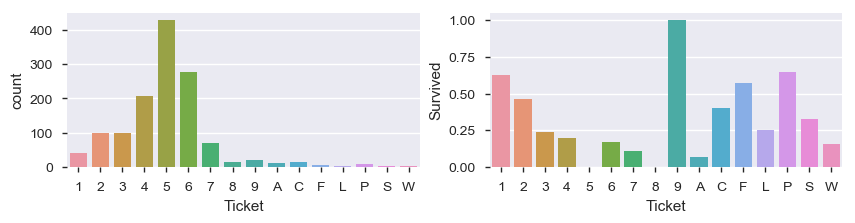

In [91]:
# inspect the amount of people for each type of tickets
#df['Ticket'].value_counts()
fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))
sns.countplot(x='Ticket', data=df, ax=axis1)
# inspect the correlatin between Ticket and Survived
#df[['Ticket','Survived']].groupby(['Ticket'], as_index=False).mean()
sex_perc = df[['Ticket','Survived']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Survived',data=sex_perc, ax=axis2)

We can see here that the majority of the tickest are "1","2","3", and their survival rates are "1">"2">"3". The rates for others are low, except for "9"(2),"C"(77),"F"(13),"P"(98), and "S"(98). "9""F" are very small samples. The high rates here are probably from Pclass or Fase. Let's check. 

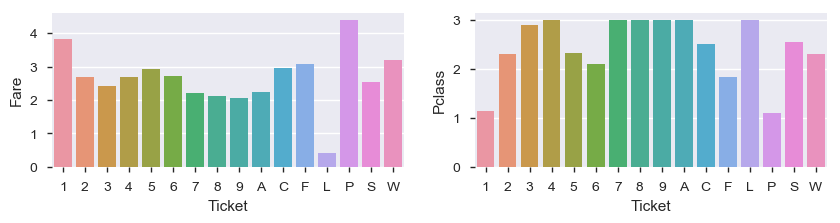

In [92]:
#df[['Ticket', 'Fare']].groupby(['Ticket'], as_index=False).mean()
#df[['Ticket', 'Pclass']].groupby(['Ticket'], as_index=False).mean()

fig, (axis1, axis2) = plt.subplots(1,2, sharex=True, figsize=(10,2))

fare_perc = df[['Ticket','Fare']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Fare',data=fare_perc, ax=axis1)
Pclass_perc = df[['Ticket','Pclass']].groupby(['Ticket'], as_index=False).mean()
sns.barplot(x='Ticket',y='Pclass',data=Pclass_perc, ax=axis2)

"Ticket" is not useful, I therefore drop this feature. 

### PassengerID

In [93]:
### Drop useless features & check the header.
df.drop(labels=['PassengerId'], axis=1, inplace=True)

# 4. Modeling and Prediction

Now we can drop useless features and split the data into training and testing sets. Then i will use various models and make predictions.

In [94]:
df.head()

,Age,Embarked,Fare,Parch,Pclass,Sex,SibSp,Survived,Ticket,Fsize_1,...,Mr,Mrs,Others,Class1,Class2,Class3,Person,Child,Female,Male
0,22.0,S,1.981001,0,3,male,1,0.0,A,0,...,1,0,0,0,0,1,0,0,0,1
1,38.0,C,4.266662,0,1,female,1,1.0,P,0,...,0,1,0,1,0,0,1,0,1,0
2,26.0,S,2.070022,0,3,female,0,1.0,S,1,...,0,1,0,0,0,1,1,0,1,0
3,35.0,S,3.972177,0,1,female,1,1.0,1,0,...,0,1,0,1,0,0,1,0,1,0
4,35.0,S,2.085672,0,3,male,0,0.0,3,1,...,1,0,0,0,0,1,0,0,0,1


In [95]:
df.drop(labels=['Embarked','Parch','Pclass','Sex','SibSp','Mr','Mrs','Others','Child','Female','Male','Title','Master','Ticket'], axis=1, inplace=True)


In [96]:
df.head()

,Age,Fare,Survived,Fsize_1,Fsize_2,Fsize_3,Fsize_4,Fsize_5,Fare_bin,Cabin_A,...,Cabin_G,Cabin_T,Cabin_X,C,Q,S,Class1,Class2,Class3,Person
0,22.0,1.981001,0.0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,38.0,4.266662,1.0,0,1,0,0,0,5,0,...,0,0,0,1,0,0,1,0,0,1
2,26.0,2.070022,1.0,1,0,0,0,0,2,0,...,0,0,1,0,0,1,0,0,1,1
3,35.0,3.972177,1.0,0,1,0,0,0,5,0,...,0,0,0,0,0,1,1,0,0,1
4,35.0,2.085672,0.0,1,0,0,0,0,2,0,...,0,0,1,0,0,1,0,0,1,0


In [ ]:
# drop redundant feasures to avoid multicollinearity
#df.drop(labels=['Fsize_5','Cabin_X','C','Class2'], axis=1, inplace=True)

In [97]:
#df.drop(labels=['Fare'], axis=1, inplace=True)

In [98]:
df.head()

,Age,Fare,Survived,Fsize_1,Fsize_2,Fsize_3,Fsize_4,Fsize_5,Fare_bin,Cabin_A,...,Cabin_G,Cabin_T,Cabin_X,C,Q,S,Class1,Class2,Class3,Person
0,22.0,1.981001,0.0,0,1,0,0,0,1,0,...,0,0,1,0,0,1,0,0,1,0
1,38.0,4.266662,1.0,0,1,0,0,0,5,0,...,0,0,0,1,0,0,1,0,0,1
2,26.0,2.070022,1.0,1,0,0,0,0,2,0,...,0,0,1,0,0,1,0,0,1,1
3,35.0,3.972177,1.0,0,1,0,0,0,5,0,...,0,0,0,0,0,1,1,0,0,1
4,35.0,2.085672,0.0,1,0,0,0,0,2,0,...,0,0,1,0,0,1,0,0,1,0


In [99]:
# Separate train and test dataset
train = df[:train_len]
test = df[train_len:]

In [100]:
X_test = test.drop(labels=["Survived"],axis = 1)

In [101]:
Y_train = train['Survived']
X_train = train.drop(labels = ['Survived'], axis=1)


## 4.1 Cross validate models
I compare 10 of the most popular classifiers and evaluate their performance using a stratified kfold cross validation procedure. 
- Logistic Regression
- Linear Discriminant Analysis
- SVC
- KNN
- Random Forest (RFC)
- Decision Tree
- Extra Trees (ExtC)
- AdaBoost (Ada)
- Gradient Boosting (GBC)
- Multiple layer perceptron (neural network)

In [102]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

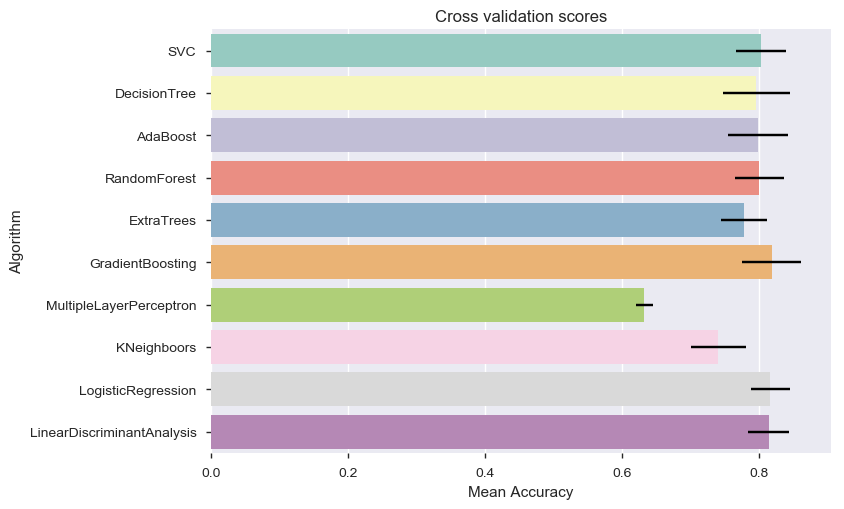

In [103]:
# Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")


I decide to choose: SVC, AdaBoost, RandomForest, GradientBoosting, logistic Regression, LDA for the ensemble modeling

## 4.2 Hyperparameter tunning for best models
- grid search optimization for the classifiers

In [ ]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

In [ ]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

In [ ]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

In [ ]:
# Logistic Regression

In [ ]:
# LDA

In [ ]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

In [ ]:
# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

## 4.3 Plot learning curves

In [ ]:
# Plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,"RF mearning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,"SVC learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost learning curves",X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting learning curves",X_train,Y_train,cv=kfold)

SVC and GradientBoosting seem to better generalize the prediction since the training and cross-validatino curves are close together. 

## 4.4 Feature importance of tree based classifiers

In [ ]:
nrows = ncols = 2
fig, axes = plt.subplots(nrows = nrows, ncols = ncols, sharex="all", figsize=(15,15))

names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],x = classifier.feature_importances_[indices][:40] , orient='h',ax=axes[row][col])
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        nclassifier += 1

In [ ]:
test_Survived_RFC = pd.Series(RFC_best.predict(X_test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(X_test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(X_test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(X_test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(X_test), name="GBC")


# Concatenate all classifier results
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)


g= sns.heatmap(ensemble_results.corr(),annot=True)

## 4.5 Ensemble modeling

In [ ]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)

In [ ]:
test_Survived = pd.Series(votingC.predict(X_test), name="Survived").astype(int)

# 5 Gernerating Submission File

In [ ]:
submission = pd.DataFrame({ "PassengerId": test_df["PassengerId"], "Survived": test_Survived})
submission.to_csv('titanic.csv', index=False)